In [23]:
import os
import gc
import re
import time
import random
import numpy as np
import pandas as pd
import csv
import copy
import glob
import math
import joblib
import pickle
import torch
import ast
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline, interp1d
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings("ignore")

def load_plt_setting():
    plt.style.use('seaborn-v0_8-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

Dataset&Dataloader

In [10]:
from sklearn.model_selection import train_test_split
dataset_train = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_train.csv")

train_set, val_set = train_test_split(dataset_train, test_size=1/9, random_state=42, shuffle=True)
test_set = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_test.csv")

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)

In [12]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Pre-loaded train/val/test dataset 
                       dataset: 'formula_spaced ', 'element_list', 'crystal_system', 'imag_avg', is_direct
                                'imag_avg': strings of Y. Y is dielectric function (a.u.), Y has constant length, covering energy(eV) range [0.,7.0,0.15]
    
    batch_size:        Batch size n.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of binary labels in (n, 0 or 1)
    formula_list:      Chemical formula for each sample
    element_list:      List of elements for each sample 
    sg_list:           Space group for each sample
    '''
    def __init__(self, dataset):
        
        self.dataset = dataset
        self.len = len(self.dataset)

    def load_data(self, batch_size = 16, shuffle=True):

        if shuffle:
            indices = np.random.permutation(self.len) 
        else:
            indices = np.arange(self.len)
        
        spectra_list = ast.literal_eval(self.dataset.iloc[0]['imag_avg'])
        spectra_len = len(spectra_list)
        
        self.Xs = np.zeros((batch_size,spectra_len,1))
        self.Ys = np.zeros((batch_size, 1))
        self.formula_list, self.element_list, self.sg_list = [], [], []

        i = 0
        while i < batch_size:
            idx = indices[i]
            sample = self.dataset.iloc[idx]
            
            formula = sample['formula_spaced']
            element_list = sample['element_list']
            sg_list = sample['crystal_system']
            spectra_list = ast.literal_eval(sample['imag_avg'])
            intensities = np.array(spectra_list)
            label = sample['is_direct']
            
            self.Xs[i, :, 0] = intensities/np.max(intensities)
            self.Ys[i] = label 

            self.formula_list.append(formula)
            self.element_list.append(element_list)
            self.sg_list.append(sg_list)

            i += 1

        return self.Xs, self.Ys, self.formula_list, self.element_list, self.sg_list

In [15]:
train_loader = DataLoader(train_set)
val_loader = DataLoader(val_set)
test_loader = DataLoader(test_set)

SVM-No fusion

In [19]:
from sklearn.metrics import log_loss
model_folder = r'/Users/shengfang/Desktop/X.051/baselines'
clf = SGDClassifier(loss='modified_huber', learning_rate='adaptive', eta0=0.01)
num_epochs = 5000
batch_size = 20
for epoch in range(num_epochs):
    Xs, Ys, *_ = train_loader.load_data(batch_size=batch_size, shuffle=True)
    Xs = Xs.squeeze(-1)                   # (batch_size, spectra_len)
    Ys = Ys.flatten().astype(int)        # (batch_size,)

    clf.partial_fit(Xs, Ys, classes=np.array([0, 1]))

    if (epoch + 1) % 10 == 0:
        y_pred_proba = clf.decision_function(Xs)
        y_pred = clf.predict(Xs)
        y_pred_prob = 1 / (1 + np.exp(-y_pred_proba))  # sigmoid

        try:
            loss = log_loss(Ys, y_pred_prob)
        except ValueError:
            loss = float('nan')

        print(f"Epoch {epoch+1}\tLoss: {loss:.5f}")
        for i, (yt, yp) in enumerate(zip(Ys[:10], y_pred_prob[:10])):
            print(f"  Sample {i+1}:  True = {yt},  Pred = {yp:.4f}")

# Save model
with open(os.path.join(model_folder, "svm_binary.pkl"), "wb") as f:
    pickle.dump(clf, f)

Epoch 10	Loss: 1.09895
  Sample 1:  True = 1,  Pred = 0.0914
  Sample 2:  True = 0,  Pred = 0.0743
  Sample 3:  True = 0,  Pred = 0.1676
  Sample 4:  True = 1,  Pred = 0.7583
  Sample 5:  True = 0,  Pred = 0.0447
  Sample 6:  True = 1,  Pred = 0.1119
  Sample 7:  True = 1,  Pred = 0.7225
  Sample 8:  True = 1,  Pred = 0.2409
  Sample 9:  True = 0,  Pred = 0.4375
  Sample 10:  True = 0,  Pred = 0.0823
Epoch 20	Loss: 0.51907
  Sample 1:  True = 0,  Pred = 0.1808
  Sample 2:  True = 0,  Pred = 0.0306
  Sample 3:  True = 1,  Pred = 0.1990
  Sample 4:  True = 0,  Pred = 0.1276
  Sample 5:  True = 1,  Pred = 0.2745
  Sample 6:  True = 0,  Pred = 0.1974
  Sample 7:  True = 0,  Pred = 0.1412
  Sample 8:  True = 0,  Pred = 0.0238
  Sample 9:  True = 0,  Pred = 0.3064
  Sample 10:  True = 0,  Pred = 0.0434
Epoch 30	Loss: 0.63138
  Sample 1:  True = 0,  Pred = 0.1149
  Sample 2:  True = 0,  Pred = 0.2605
  Sample 3:  True = 0,  Pred = 0.1217
  Sample 4:  True = 0,  Pred = 0.5540
  Sample 5:  True

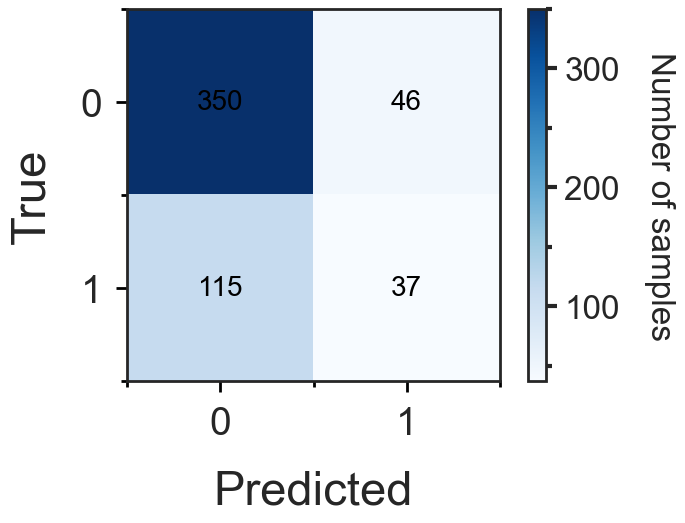

Accuracy: 0.7062
F1 Score: 0.3149


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Load test set
test_set = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_test.csv")

# Convert imag_avg column (stored as string) to list of floats
Xs = np.array([eval(x) for x in test_set['imag_avg']])
Xs = Xs / np.max(Xs, axis=1, keepdims=True)  # Normalize
Ys = test_set['is_direct'].values.astype(int)

# Load trained model
model_path = "/Users/shengfang/Desktop/X.051/baselines/svm_binary.pkl"
with open(model_path, "rb") as f:
    clf = pickle.load(f)

# Predict
y_pred = clf.predict(Xs)

# Classification report
report = classification_report(Ys, y_pred, output_dict=True)
matrix = confusion_matrix(Ys, y_pred)
acc = accuracy_score(Ys, y_pred)

load_plt_setting()
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
mat = ax.matshow(matrix, cmap='Blues')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=20, color='black')

ax.set_xlabel(r'Predicted', labelpad=20, fontsize=34)
ax.set_ylabel(r'True', labelpad=20, fontsize=34)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

# Colorbar
cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=24)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90, fontsize=24)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

# Save figure
plt.tight_layout()
plt.savefig("/Users/shengfang/Desktop/X.051/figures/svm_nofusion.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# Also print accuracy and F1
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_score(Ys, y_pred):.4f}")

CNN-No fusion

In [39]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.con1 = nn.LazyConv1d(64, 50, stride=2)
        self.poo1 = nn.MaxPool1d(3, stride=2)
        self.con2 = nn.LazyConv1d(64, 25, stride=3)
        self.poo2 = nn.MaxPool1d(2, stride=3)
        self.fc1 = nn.LazyLinear(2000)
        self.fc2 = nn.LazyLinear(500)
        self.fc3 = nn.LazyLinear(1)  # Binary classification output

    def forward(self, x):
        x = self.con1(x)
        x = self.poo1(x)
        x = self.con2(x)
        x = self.poo2(x)
        x = self.fc1(torch.flatten(x, start_dim=1))
        x = self.fc2(x)
        x = self.fc3(x)
        return x  # logits, no sigmoid here

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_folder = "/Users/shengfang/Desktop/X.051/baselines"

batch_size = 20
num_epochs = 5000

model = CNNModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

train_losses, train_y_true, train_y_pred = [], [], []

time_start = time.time()
for epoch in range(num_epochs):
    Xs, Ys, *_ = train_loader.load_data(batch_size=batch_size, shuffle=True)

    # Xs: (batch_size, spectrum_len, 1) → (batch_size, 1, spectrum_len)
    Xs_tensor = torch.tensor(Xs.squeeze(-1), dtype=torch.float32).unsqueeze(1).to(device)
    Ys_tensor = torch.tensor(Ys, dtype=torch.float32).to(device)

    num_pos = Ys_tensor.sum()
    num_neg = len(Ys_tensor) - num_pos
    pos_weight_val = num_neg / (num_pos + 1e-8)
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    logits = model(Xs_tensor) # shape (batch_size, 1)
    loss = loss_fn(logits, Ys_tensor)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    y_pred = torch.sigmoid(logits).detach().cpu().numpy()
    y_true = Ys_tensor.cpu().numpy()

    train_losses.append(loss.item())
    train_y_true.append(y_true)
    train_y_pred.append(y_pred)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}\tLoss: {loss.item():.5f}")
        for i, (yt, yp) in enumerate(zip(y_true[:10], y_pred[:10])):
            print(f" True = {int(yt)},  Pred = {yp[0]:.4f}")

# Save model 
torch.save(model.state_dict(), os.path.join(model_folder, f"CNN_nofusion.pt"))
np.savetxt(os.path.join(model_folder, "train_loss_cnn.csv"), train_losses, delimiter=',')

del model

Epoch 10	Loss: 1.34219
 True = 0,  Pred = 0.5690
 True = 0,  Pred = 0.5855
 True = 0,  Pred = 0.5875
 True = 0,  Pred = 0.5944
 True = 0,  Pred = 0.5715
 True = 0,  Pred = 0.5947
 True = 0,  Pred = 0.5776
 True = 0,  Pred = 0.5848
 True = 0,  Pred = 0.5724
 True = 0,  Pred = 0.5855
Epoch 20	Loss: 0.76297
 True = 0,  Pred = 0.4969
 True = 0,  Pred = 0.5450
 True = 1,  Pred = 0.4638
 True = 0,  Pred = 0.4373
 True = 0,  Pred = 0.4317
 True = 1,  Pred = 0.5474
 True = 0,  Pred = 0.4272
 True = 0,  Pred = 0.4828
 True = 1,  Pred = 0.4386
 True = 0,  Pred = 0.5436
Epoch 30	Loss: 1.09029
 True = 0,  Pred = 0.4638
 True = 1,  Pred = 0.4188
 True = 0,  Pred = 0.4036
 True = 0,  Pred = 0.5241
 True = 0,  Pred = 0.5538
 True = 0,  Pred = 0.3908
 True = 0,  Pred = 0.5592
 True = 0,  Pred = 0.5570
 True = 0,  Pred = 0.3787
 True = 0,  Pred = 0.3892
Epoch 40	Loss: 0.92101
 True = 1,  Pred = 0.4444
 True = 1,  Pred = 0.6179
 True = 0,  Pred = 0.5719
 True = 1,  Pred = 0.6274
 True = 0,  Pred = 0.599

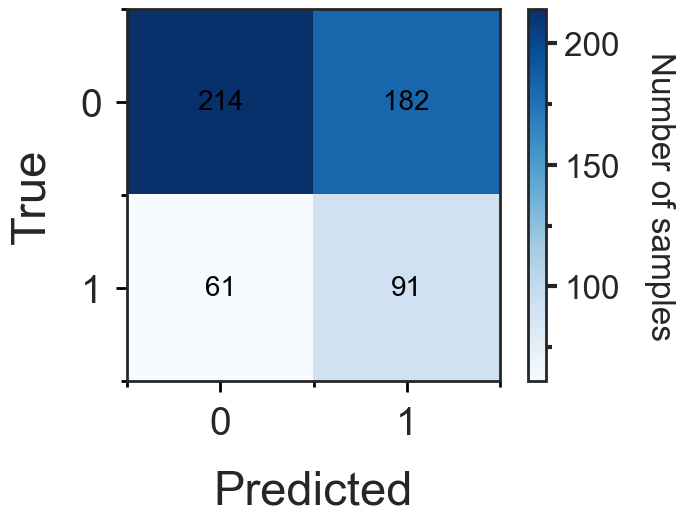

Accuracy: 0.5566
F1 Score: 0.4282


In [51]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

test_set = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_test.csv")
Xs = np.array([eval(x) for x in test_set['imag_avg']])
Xs = Xs / np.max(Xs, axis=1, keepdims=True)  # normalize
Ys = test_set['is_direct'].values.astype(int)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load("/Users/shengfang/Desktop/X.051/baselines/CNN_nofusion.pt", map_location=device))
model.eval()

# Prepare test input and get predictions
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, spectrum_len)

with torch.no_grad():
    logits = model(Xs_tensor).squeeze(1)
    y_pred_prob = torch.sigmoid(logits).cpu().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

# Classification metrics
report = classification_report(Ys, y_pred, output_dict=True)
matrix = confusion_matrix(Ys, y_pred)
acc = accuracy_score(Ys, y_pred)

# Plot confusion matrix 
fig, ax = plt.subplots(figsize=(8, 6))
mat = ax.matshow(matrix, cmap='Blues')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=20, color='black')

ax.set_xlabel(r'Predicted', labelpad=20, fontsize=34)
ax.set_ylabel(r'True', labelpad=20, fontsize=34)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

# Colorbar
cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=24)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90, fontsize=24)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

# Save figure
plt.tight_layout()
plt.savefig("/Users/shengfang/Desktop/X.051/figures/cnn_nofusion.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_score(Ys, y_pred):.4f}")


Transformer - No fusion

In [54]:
class VisualTransformerClassifier(nn.Module):
    def __init__(self, embedding_dim=20, seq_len=23, nhead=2, num_layers=2):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(seq_len, 1, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=False  # required for classic transformer
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # binary output
        )

    def forward(self, x):  # x: (batch_size, 23, embedding_dim)
        x = x.permute(1, 0, 2)  # → (23, batch_size, embedding_dim)
        x = x + self.pos_embedding  # add positional encoding
        x = self.encoder(x)         # → (23, batch_size, embedding_dim)
        x = x.mean(dim=0)           # → (batch_size, embedding_dim)
        return self.fc(x)           # → (batch_size, 1)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_folder = "/Users/shengfang/Desktop/X.051/baselines"

batch_size = 20
num_epochs = 5000
visual_embedding_dim = 20

model = VisualTransformerClassifier(embedding_dim=visual_embedding_dim, seq_len=23).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)

train_losses, train_y_true, train_y_pred = [], [], []

time_start = time.time()
for epoch in range(num_epochs):
    Xs, Ys, *_ = train_loader.load_data(batch_size=batch_size, shuffle=True)

    # Preprocess Xs: (batch_size, spectrum_len, 1) → (batch_size, seq_len, embedding_dim)
    len_dim = (Xs.shape[1] // visual_embedding_dim) * visual_embedding_dim
    Xs = Xs[:, :len_dim, :]
    Xs = Xs.reshape((Xs.shape[0], -1, visual_embedding_dim))  # (batch_size, seq_len, embedding_dim)

    Xs_tensor = torch.tensor(Xs, dtype=torch.float32).to(device)
    Ys_tensor = torch.tensor(Ys, dtype=torch.float32).to(device)

    # Handle class imbalance
    num_pos = Ys_tensor.sum()
    num_neg = len(Ys_tensor) - num_pos
    pos_weight_val = num_neg / (num_pos + 1e-8)
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    logits = model(Xs_tensor)  # (B,)

    loss = loss_fn(logits, Ys_tensor)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    y_pred = torch.sigmoid(logits).detach().cpu().numpy()
    y_true = Ys_tensor.cpu().numpy()

    train_losses.append(loss.item())
    train_y_true.append(y_true)
    train_y_pred.append(y_pred)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}\tLoss: {loss.item():.5f}")
        for i, (yt, yp) in enumerate(zip(y_true[:10], y_pred[:10])):
            print(f" True = {int(yt)},  Pred = {float(yp):.4f}")

# Save model
torch.save(model.state_dict(), os.path.join(model_folder, "Transformer_nofusion.pt"))
np.savetxt(os.path.join(model_folder, "train_loss_transformer.csv"), train_losses, delimiter=',')

del model

Epoch 10	Loss: 1.25136
 True = 1,  Pred = 0.5032
 True = 0,  Pred = 0.5044
 True = 0,  Pred = 0.5046
 True = 0,  Pred = 0.5021
 True = 0,  Pred = 0.5056
 True = 0,  Pred = 0.4984
 True = 0,  Pred = 0.4994
 True = 0,  Pred = 0.5006
 True = 0,  Pred = 0.5029
 True = 0,  Pred = 0.5049
Epoch 20	Loss: 0.90422
 True = 0,  Pred = 0.4953
 True = 1,  Pred = 0.4986
 True = 0,  Pred = 0.4951
 True = 0,  Pred = 0.5013
 True = 0,  Pred = 0.5007
 True = 1,  Pred = 0.4998
 True = 1,  Pred = 0.4973
 True = 0,  Pred = 0.4956
 True = 0,  Pred = 0.4991
 True = 0,  Pred = 0.4918
Epoch 30	Loss: 0.96799
 True = 0,  Pred = 0.4993
 True = 1,  Pred = 0.4979
 True = 1,  Pred = 0.5027
 True = 0,  Pred = 0.4980
 True = 0,  Pred = 0.4965
 True = 0,  Pred = 0.4971
 True = 1,  Pred = 0.5010
 True = 0,  Pred = 0.4965
 True = 0,  Pred = 0.4972
 True = 0,  Pred = 0.4987
Epoch 40	Loss: 0.89936
 True = 1,  Pred = 0.5021
 True = 1,  Pred = 0.5004
 True = 0,  Pred = 0.5035
 True = 0,  Pred = 0.4974
 True = 1,  Pred = 0.501

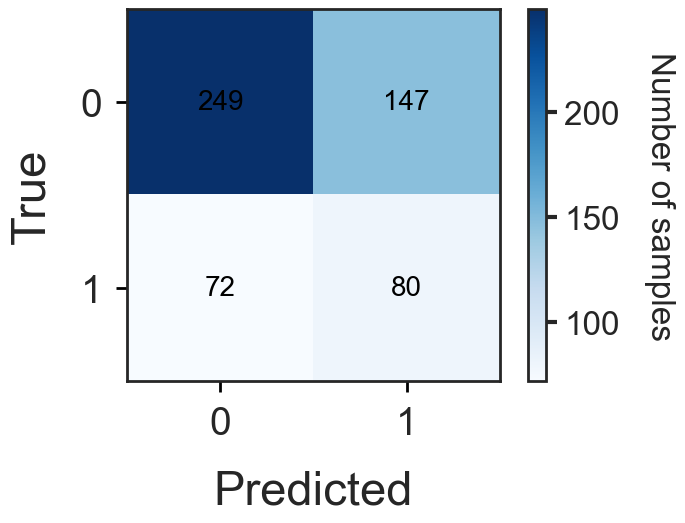

Accuracy: 0.6004
F1 Score: 0.4222


In [64]:
test_set = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_test.csv")
Xs = np.array([eval(x) for x in test_set['imag_avg']])
Xs = Xs / np.max(Xs, axis=1, keepdims=True)
Ys = test_set['is_direct'].values.astype(int)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisualTransformerClassifier(embedding_dim=20, seq_len=23).to(device)
model.load_state_dict(torch.load("/Users/shengfang/Desktop/X.051/baselines/Transformer_nofusion.pt", map_location=device))
model.eval()

Xs = Xs[:, :460]  # ensure divisible by 20
Xs = Xs.reshape((Xs.shape[0], 23, 20))  # → (batch_size, seq_len, embedding_dim)
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).to(device)

with torch.no_grad():
    logits = model(Xs_tensor)
    y_pred_prob = torch.sigmoid(logits).cpu().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(Ys, y_pred, output_dict=True)
matrix = confusion_matrix(Ys, y_pred)
acc = accuracy_score(Ys, y_pred)

# Plot confusion matrix 
fig, ax = plt.subplots(figsize=(8, 6))
mat = ax.matshow(matrix, cmap='Blues')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, color='black', labelsize=28)
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10, color='black', labelsize=28)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=20, color='black')

ax.set_xlabel("Predicted", labelpad=20, fontsize=34)
ax.set_ylabel("True", labelpad=20, fontsize=34)

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out', length=8, width=3, pad=5, labelsize=24)
cbar.ax.set_ylabel('Number of samples', labelpad=40, rotation=-90, fontsize=24)

plt.tight_layout()
plt.savefig("/Users/shengfang/Desktop/X.051/figures/transformer_nofusion.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_score(Ys, y_pred):.4f}")

In [66]:
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn

class VisualBERTLateFusion(nn.Module):
    def __init__(self, visual_dim=20, seq_len=23):
        super().__init__()

        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")

        self.pos_embedding = nn.Parameter(torch.randn(seq_len, 1, visual_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=visual_dim, nhead=2, dim_feedforward=128, dropout=0.1)
        self.visual_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Fusion and classifier
        text_dim = self.text_encoder.config.hidden_size
        self.fc = nn.Sequential(
            nn.Linear(text_dim + visual_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # binary classification
        )

    def forward(self, input_ids, attention_mask, visual_embeds):

        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_text = text_outputs.pooler_output  # (B, 768)

        visual_embeds = visual_embeds.permute(1, 0, 2)  # (S, B, D)
        visual_encoded = self.visual_encoder(visual_embeds + self.pos_embedding)
        pooled_visual = visual_encoded.mean(dim=0)  # (B, D)

        combined = torch.cat([cls_text, pooled_visual], dim=1)  # (B, 768+D)
        logits = self.fc(combined)  # (B, 1)

        return logits

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = VisualBERTLateFusion().to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)

model_folder = "/Users/shengfang/Desktop/X.051/baselines"
batch_size = 20
num_epochs = 5000
visual_embedding_dim = 20

train_losses, train_y_true, train_y_pred = [], [], []
time_start = time.time()

for epoch in range(num_epochs):
    Xs, Ys, formula_list, element_list, sg_list = train_loader.load_data(batch_size=batch_size, shuffle=True)

    len_dim = (Xs.shape[1] // visual_embedding_dim) * visual_embedding_dim
    Xs = Xs[:, :len_dim, :]
    Xs = Xs.reshape((Xs.shape[0], -1, visual_embedding_dim))  # (batch_size, seq_len, visual_embedding_dim)
    visual_tensor = torch.tensor(Xs, dtype=torch.float32).to(device)

    prompts = [f"{f} {' '.join(elems)} {sg}" for f, elems, sg in zip(formula_list, element_list, sg_list)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    Ys_tensor = torch.tensor(Ys, dtype=torch.float32).to(device)

    num_pos = Ys_tensor.sum()
    num_neg = len(Ys_tensor) - num_pos
    pos_weight_val = num_neg / (num_pos + 1e-8)
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    logits = model(input_ids=inputs["input_ids"],
                   attention_mask=inputs["attention_mask"],
                   visual_embeds=visual_tensor)
    loss = loss_fn(logits, Ys_tensor)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    y_pred = torch.sigmoid(logits).detach().cpu().numpy()
    y_true = Ys_tensor.cpu().numpy()

    train_losses.append(loss.item())
    train_y_true.append(y_true)
    train_y_pred.append(y_pred)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}\tLoss: {loss.item():.5f}")
        for i, (yt, yp) in enumerate(zip(y_true[:10], y_pred[:10])):
            print(f" True = {int(yt)},  Pred = {float(yp):.4f}")

torch.save(model.state_dict(), os.path.join(model_folder, "ViT_latefusion.pt"))
np.savetxt(os.path.join(model_folder, "train_loss_latefusion.csv"), train_losses, delimiter=',')

del model

Epoch 10	Loss: 0.87064
 True = 0,  Pred = 0.5784
 True = 1,  Pred = 0.5589
 True = 0,  Pred = 0.5853
 True = 0,  Pred = 0.5642
 True = 0,  Pred = 0.4094
 True = 0,  Pred = 0.5410
 True = 1,  Pred = 0.5521
 True = 0,  Pred = 0.5221
 True = 0,  Pred = 0.4012
 True = 0,  Pred = 0.5474
Epoch 20	Loss: 0.76446
 True = 1,  Pred = 0.4201
 True = 1,  Pred = 0.4138
 True = 0,  Pred = 0.4120
 True = 0,  Pred = 0.4230
 True = 0,  Pred = 0.4194
 True = 0,  Pred = 0.4110
 True = 0,  Pred = 0.4126
 True = 1,  Pred = 0.4139
 True = 1,  Pred = 0.7310
 True = 0,  Pred = 0.4213
Epoch 30	Loss: 0.84166
 True = 0,  Pred = 0.3724
 True = 0,  Pred = 0.7955
 True = 1,  Pred = 0.4350
 True = 0,  Pred = 0.5685
 True = 0,  Pred = 0.7955
 True = 0,  Pred = 0.3699
 True = 0,  Pred = 0.5647
 True = 0,  Pred = 0.4216
 True = 0,  Pred = 0.7988
 True = 1,  Pred = 0.7942
Epoch 40	Loss: 0.71509
 True = 1,  Pred = 0.3607
 True = 0,  Pred = 0.3672
 True = 1,  Pred = 0.3606
 True = 0,  Pred = 0.3636
 True = 1,  Pred = 0.753

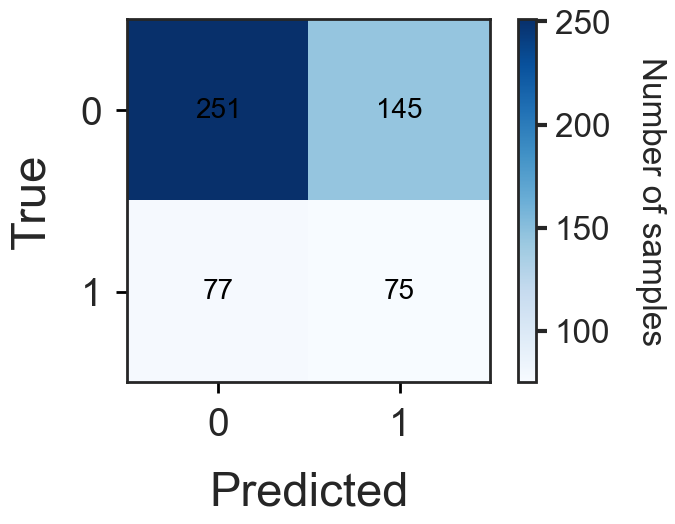

Accuracy: 0.5949
F1 Score: 0.4032


In [73]:
test_set = pd.read_csv("/Users/shengfang/Desktop/X.051/dataset_test.csv")
Xs = np.array([eval(x) for x in test_set['imag_avg']])
Xs = Xs / np.max(Xs, axis=1, keepdims=True)
Ys = test_set['is_direct'].values.astype(int)

Xs = Xs[:, :460]
Xs = Xs.reshape((Xs.shape[0], 23, 20))  # → (batch_size, seq_len, visual_embedding_dim)
visual_tensor = torch.tensor(Xs, dtype=torch.float32)

formula_list = test_set['formula_spaced'].tolist()
element_list = test_set['element_list'].tolist()
sg_list = test_set['crystal_system'].tolist()
prompts = [f"{f} {' '.join(eval(elems))} {sg}" for f, elems, sg in zip(formula_list, element_list, sg_list)]

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)
model = VisualBERTLateFusion().to(device)
model.load_state_dict(torch.load("/Users/shengfang/Desktop/X.051/baselines/ViT_latefusion.pt", map_location=device))
model.eval()

with torch.no_grad():
    logits = model(
        input_ids=inputs["input_ids"].to(device),
        attention_mask=inputs["attention_mask"].to(device),
        visual_embeds=visual_tensor.to(device)
    )

    y_pred_prob = torch.sigmoid(logits).cpu().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(Ys, y_pred, output_dict=True)
matrix = confusion_matrix(Ys, y_pred)
acc = accuracy_score(Ys, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
mat = ax.matshow(matrix, cmap='Blues')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='both', direction='out', length=8, width=2, pad=10, color='black', labelsize=28)
ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=10, color='black', labelsize=28)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=20, color='black')

ax.set_xlabel("Predicted", labelpad=20, fontsize=34)
ax.set_ylabel("True", labelpad=20, fontsize=34)

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out', length=8, width=3, pad=5, labelsize=24)
cbar.ax.set_ylabel('Number of samples', labelpad=40, rotation=-90, fontsize=24)

plt.tight_layout()
plt.savefig("/Users/shengfang/Desktop/X.051/figures/visualbert_latefusion.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_score(Ys, y_pred):.4f}")